In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

In [3]:
d = pd.read_csv("sample_clean.csv")
ds = pd.read_csv("santos_sample_clean.csv")

In [4]:
rnlabel = "variability amplitude $S_\mathrm{ph}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ or $3.6S_\mathrm{ph}$ (ppm)"
rperlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = "empirical threshold\nin the McQuillan sample"#'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'
col = 'gray'

In [5]:
plotdir = 'systematics/'

## McQuillan vs Santos

In [6]:
params_all = {"robreak": 0.84, "Rbreak": 1.08e4, "bsat": -0.04, "bunsat": -2.61, "lnrsigma": 0.55}
params_mag = {"robreak": 0.99, "Rbreak": 9.7e3, "bsat": -0.02, "bunsat": -4.55, "lnrsigma": 0.59}
def rper_ro(ro, p, scatter=False):
    ro = np.atleast_1d(ro)
    ret = (ro/p['robreak'])**p['bsat']
    idx = ro > p['robreak']
    ret[idx] = (ro[idx]/p['robreak'])**p['bunsat']
    if not scatter:
        return ret * p['Rbreak']
    else:
        lnR = np.log(ret * p['Rbreak']) + np.random.randn(len(ret))*p['lnrsigma']
        return np.exp(lnR)

In [7]:
ds['Sph'] = np.array(ds.Rper)

In [8]:
dmerged = pd.merge(d[['kepid', 'Rper']], ds[['kepid', 'Sph']], on='kepid')
print ('Rper/Sph median:', np.median(dmerged.Rper/dmerged.Sph))

Rper/Sph median: 3.6179050362360554


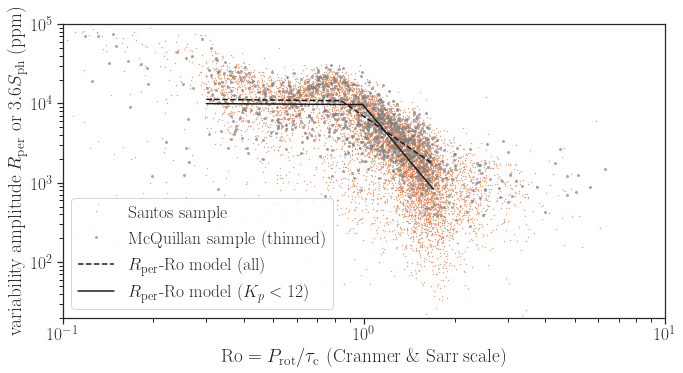

In [45]:
scale = 3.6
col2 = 'skyblue'
col2 = 'k'
r0 = np.logspace(np.log10(0.3), np.log10(1.7), 1000)
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$ (Cranmer \& Sarr scale)")
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.ylim(20, 1e5)
idxs = (ds.teff>4000) & (ds.teff<6250)
plt.plot(ds.Pnorm[idxs], ds.Rper[idxs]*scale, '.', markersize=0.7, color='C1', label='Santos sample')
#idxm = d.kepmag < 12
idxm = d.index%5 == 0
plt.plot(d.Pnorm[idxm], d.Rper[idxm], 'o', markersize=2., color=col, 
         label='McQuillan sample (thinned)', alpha=0.6)#, mfc='none', mew=0.5, alpha=1)
plt.plot(r0, rper_ro(r0, params_all), label='$R_\mathrm{per}$-$\mathrm{Ro}$ model (all)', color=col2, ls='dashed')
plt.plot(r0, rper_ro(r0, params_mag), label='$R_\mathrm{per}$-$\mathrm{Ro}$ model ($K_p<12$)', color=col2, ls='solid')
plt.legend(loc='best')
#plt.axvline(x=1.6)
plt.savefig(plotdir+"mcquillan_santos_teffcut.png", dpi=200, bbox_inches="tight")

In [46]:
def mfilter(x, y, dx, N=100, mean=False, Nmin=10):
    xarr = np.linspace(x.min(), x.max(), N)
    yarr = []
    yfilt = []
    yl, yu = [], []
    for i in range(len(xarr)):
        idx = np.abs(x - xarr[i]) < dx
        if np.sum(idx) > Nmin:
            if mean:
                yfilt.append(np.mean(y[idx]))
            else:
                yfilt.append(np.median(y[idx]))
        else:
            yfilt.append(np.nan)
    return xarr, np.array(yfilt)

In [67]:
np.sum(idxs)

7621

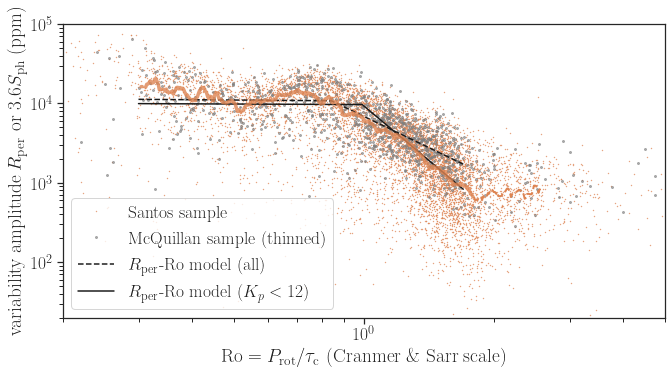

In [76]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$ (Cranmer \& Sarr scale)")
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1*2, 10/2.)
plt.ylim(20, 1e5)
idxs = (ds.teff>4000) & (ds.teff<6250)
plt.plot(ds.Pnorm[idxs], ds.Rper[idxs]*scale, '.', markersize=0.7, color='C1', label='Santos sample')
#idxm = d.kepmag < 12
idxm = d.index%5 == 0
plt.plot(d.Pnorm[idxm], d.Rper[idxm], 'o', markersize=2., color=col, 
         label='McQuillan sample (thinned)', alpha=0.6)#, mfc='none', mew=0.5, alpha=1)
plt.plot(r0, rper_ro(r0, params_all), label='$R_\mathrm{per}$-$\mathrm{Ro}$ model (all)', color=col2, ls='dashed')
plt.plot(r0, rper_ro(r0, params_mag), label='$R_\mathrm{per}$-$\mathrm{Ro}$ model ($K_p<12$)', color=col2, ls='solid')
xfilt, yfilt = mfilter(np.log10(ds.Pnorm[idxs]), np.log10(ds.Rper[idxs]*scale), 0.01, N=1000, mean=False, Nmin=30)
xfilt, yfilt = 10**xfilt, 10**yfilt
plt.plot(xfilt[xfilt<1.8], yfilt[xfilt<1.8], '-', #label='median filter (0.06dex)', 
         color='C1', lw=3.5, alpha=0.8, label='')
plt.plot(xfilt[xfilt>1.8], yfilt[xfilt>1.8], '-', #label='median filter (0.06dex)', 
         color='C1', lw=2., alpha=1, label='', ls='dashed')
plt.legend(loc='best')
plt.savefig(plotdir+"mcquillan_santos_teffcut2.png", dpi=200, bbox_inches="tight")

## tauc prescription

### Corsaro et al. (2021); only for bluer stars

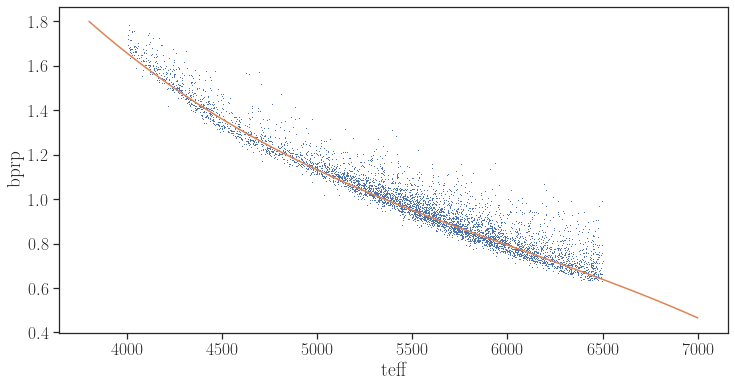

In [10]:
def iterative_fit(x, y, order, nsigma=[1.,3.], maxniter=10):
    A = np.vander(x, order+1)
    idx = np.ones_like(x) > 0
    for i in range(maxniter):
        w = np.linalg.solve(np.dot(A[idx].T, A[idx]), np.dot(A[idx].T, y[idx]))
        mu = np.dot(A, w)
        res = y - mu
        sigma = np.sqrt(np.median(res**2))
        idx_new = (res > -nsigma[0]*sigma) & (res < nsigma[1]*sigma)
        if np.sum(idx)==np.sum(idx_new):
            idx = idx_new
            break
        idx = idx_new
    return mu, w

x, y = d.teff, d.bp_rp
_idx = (x==x) & (y==y)
_order = 3
x, y = (x[_idx]-5500.)/500., y[_idx]
mu, w = iterative_fit(x, y, _order, nsigma=[3.,2.])
bprpfunc = lambda teff: np.dot(np.vander((teff - 5500) / 500., _order+1), w)
t0 = np.linspace(3800, 7000, 100)
teff2bprp = np.poly1d(np.polyfit(x, y, deg=7))
plt.plot(d.teff, d.bp_rp, ',')
plt.xlabel("teff")
plt.ylabel("bprp")
plt.plot(t0, bprpfunc(t0))

In [11]:
def tau_g98(teff):
    return 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

def tau_c21(bprp, b1=-134.0, b2=341.7, b3=-150.6): # not valid for bprp>1
    ret = b1 + bprp * (b2 + b3 * bprp)
    ret[bprp>1.] = b1 + b2 + b3
    return ret

### Lehtinen et al. (2021) YaPSI

In [12]:
def float_keys(d, keys):
    for k in keys:
        arr = []
        for i in range(len(d)):
            val = d[k][i]
            try:
                arr.append(float(val))
            except:
                arr.append(np.nan)
        d[k] = arr
    return d
from scipy.interpolate import interp1d
dconv = pd.read_csv("data/EEM_dwarf_UBVIJHK_colors_Teff.txt", comment='#', delim_whitespace=True)
dconv = float_keys(dconv, ['Teff', 'B-V', 'V-Ks', 'Msun'])
bvfromt = interp1d(dconv['Teff'], dconv['B-V'])

In [13]:
def tau_n84(bv):
    #bv = bvfromt(np.atleast_1d(teff))
    x = 1. - np.atleast_1d(bv)
    ret = 1.362 - 0.166 * x + 0.025 * x**2 - 5.323 * x**3
    ret[x<0] = 1.362 - 0.14 * x[x<0]
    return 10**ret

def tauconv_l21(tau):
    return -30.7 + 15.2*tau - 2.16*tau**2 + 0.192*tau**3 - 0.00839*tau**4 + 0.000141*tau**5

def tau_l21(teff):
    t84 = tau_n84(bvfromt(teff))
    return tauconv_l21(t84)

In [14]:
d['bp_rp-est'] = bprpfunc(d.teff)
d['tauc21-est'] = tau_c21(d['bp_rp-est'])
d['Pnormc21'] = d.Prot / d['tauc21-est'] 
d['taul21'] = tau_l21(d.teff)
d['Pnorml21'] = d.Prot / d['taul21']
rosun_g98 = 25. / tau_g98(5778)
rosun_c21 = 25. / tau_c21(np.array([0.82]))[0]
rosun_l21 = 25. / tau_l21(5778)[0]
print (rosun_g98, rosun_c21, rosun_l21)

1.956491198325513 0.5564141644350751 0.7556305252112456


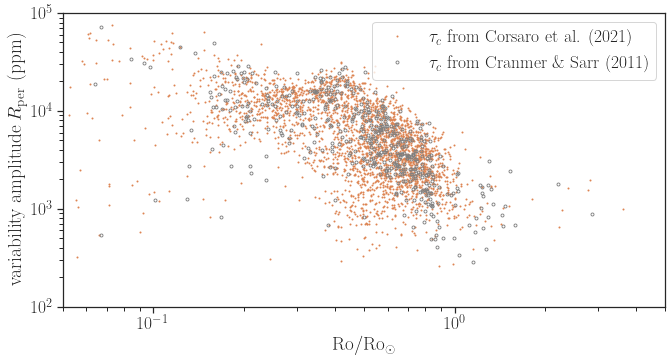

In [32]:
scale = 3.
col2 = 'skyblue'
r0 = np.logspace(-1, 1, 100)
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel("$\mathrm{Ro}/\mathrm{Ro}_\odot$")
plt.ylabel(rperlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.05, 5)
plt.ylim(1e2, 1e5)
#plt.plot(ds.Pnorm, ds.Rper*scale, '.', markersize=1., color='C1', label='Santos')
#plt.plot(d.Pnorm/rosun_g98, d.Rper, '.', markersize=1., color=col, label='CS11')
idxc = (d['bp_rp-est'] < 1.) & (d.teff<6250.) & (d.teff>4000.)
plt.plot(d.Pnormc21[idxc]/rosun_c21, d.Rper[idxc], 'o', markersize=1., color='C1', 
         label=r'$\tau_c$ from Corsaro et al. (2021)')

idxm = (d.index%10 == 0) #& (d.teff<6250.) & (d.teff>4000.)
plt.plot(d.Pnorm[idxm]/rosun_g98, d.Rper[idxm], 'o', markersize=3., 
         color=col,  alpha=1, mfc='none', mew=0.9,
         label=r'$\tau_c$ from Cranmer \& Sarr (2011)')
#plt.plot(r0/rosun_g98, rper_ro(r0, params_all), label='M14 all', color=col2, ls='dashed')
#plt.plot(r0/rosun_g98, rper_ro(r0, params_mag), label='M14 Kp<12', color=col2, ls='solid')

plt.legend(loc='best')
plt.savefig(plotdir+"tauc_c21_teffcut.png", dpi=200, bbox_inches="tight")

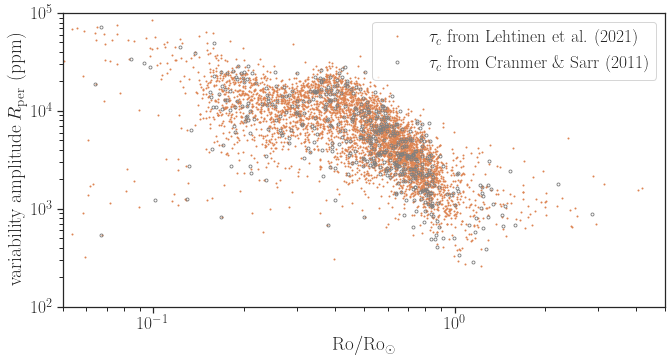

In [34]:
scale = 3.
col2 = 'skyblue'
r0 = np.logspace(-1, 1, 100)
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel("$\mathrm{Ro}/\mathrm{Ro}_\odot$")
plt.ylabel(rperlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.05, 5)
plt.ylim(1e2, 1e5)
#plt.plot(ds.Pnorm, ds.Rper*scale, '.', markersize=1., color='C1', label='Santos')
#plt.plot(d.Pnorm/rosun_g98, d.Rper, '.', markersize=1., color=col, label='CS11')
idxc = (d.taul21==d.taul21) & (d.teff<6250.) & (d.teff>4000.)
plt.plot(d.Pnorml21[idxc]/rosun_l21, d.Rper[idxc], 'o', markersize=1., color='C1', 
         label=r'$\tau_c$ from Lehtinen et al. (2021)')

idxm = d.index%10 == 0
plt.plot(d.Pnorm[idxm]/rosun_g98, d.Rper[idxm], 'o', markersize=3., 
         color=col,  alpha=1, mfc='none', mew=0.9,
         label=r'$\tau_c$ from Cranmer \& Sarr (2011)')
#plt.plot(r0/rosun_g98, rper_ro(r0, params_all), label='M14 all', color=col2, ls='dashed')
#plt.plot(r0/rosun_g98, rper_ro(r0, params_mag), label='M14 Kp<12', color=col2, ls='solid')

plt.legend(loc='best')
plt.savefig(plotdir+"tauc_l21_teffcut.png", dpi=200, bbox_inches="tight")

In [18]:
d.to_csv("sample_clean_tau.csv", index=False)

In [19]:
len(d)

4968

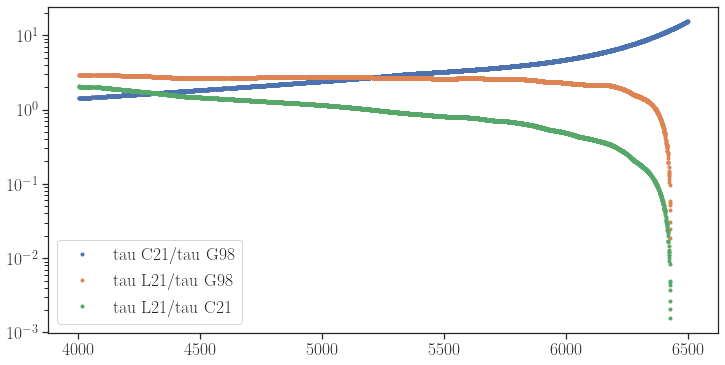

In [43]:
plt.yscale("log")
plt.plot(d.teff, d.Pnorm/d.Pnormc21, '.', label='tau C21/tau G98')
plt.plot(d.teff, d.Pnorm/d.Pnorml21, '.', label='tau L21/tau G98')
plt.plot(d.teff, d.Pnormc21/d.Pnorml21, '.', label='tau L21/tau C21')
plt.legend();